In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl", 7)
sns.set_context("talk")

In [8]:
def analyze_splus_internal_consistency(df, aperture=4):
    """
    Analizar la consistencia interna de la fotometría SPLUS
    """
    # Primero, asegurémonos de que todas las columnas numéricas sean realmente numéricas
    def safe_numeric_conversion(series):
        """Convertir una serie a numérico, manejando valores no numéricos"""
        return pd.to_numeric(series, errors='coerce')
    
    # Convertir todas las columnas de magnitud y error a numéricas
    for col in df.columns:
        if col.startswith(('MAG_', 'MAGERR_', 'FLUX_', 'FLUXERR_')):
            df[col] = safe_numeric_conversion(df[col])
    
    # Definir los filtros SPLUS en orden de longitud de onda
    filters = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']
    filter_names = ['F378 (u)', 'F395 (u)', 'F410 (CaHK)', 'F430 (G-band)', 
                   'F515 (g)', 'F660 (r)', 'F861 (CaT)']
    
    # Crear máscara de datos válidos
    valid_mask = np.ones(len(df), dtype=bool)
    for filt in filters:
        mag_col = f'MAG_{filt}_{aperture}'
        if mag_col in df.columns:
            # Filtrar valores no válidos (99.0, NaN, y fuera de rango razonable)
            valid_mask &= (df[mag_col] < 90) & (df[mag_col] > 10) & (~df[mag_col].isna())
    
    df_valid = df[valid_mask].copy()
    
    print(f"Fuentes con fotometría completa: {len(df_valid)}")
    
    if len(df_valid) == 0:
        print("No hay suficientes datos válidos para el análisis")
        return df
    
    # 1. Distribución de magnitudes por filtro
    plt.figure(figsize=(14, 8))
    for i, filt in enumerate(filters):
        mag_col = f'MAG_{filt}_{aperture}'
        if mag_col in df_valid.columns:
            # Asegurarnos de que los datos sean numéricos
            mag_data = pd.to_numeric(df_valid[mag_col], errors='coerce')
            mag_data = mag_data[~mag_data.isna() & (mag_data < 90) & (mag_data > 10)]
            if len(mag_data) > 0:
                plt.hist(mag_data, bins=30, alpha=0.7, label=filter_names[i])
    
    plt.xlabel('Magnitud')
    plt.ylabel('Número de cúmulos')
    plt.title('Distribución de magnitudes por filtro (apertura de 4 arcsec)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('splus_magnitude_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Diagramas de color-color
    # Calcular todos los colores primero
    colors = {}
    for i in range(len(filters)-1):
        for j in range(i+1, len(filters)):
            color_name = f'{filters[i]}-{filters[j]}'
            mag1_col = f'MAG_{filters[i]}_{aperture}'
            mag2_col = f'MAG_{filters[j]}_{aperture}'
            
            if mag1_col in df_valid.columns and mag2_col in df_valid.columns:
                # Asegurar que ambas columnas sean numéricas
                mag1 = pd.to_numeric(df_valid[mag1_col], errors='coerce')
                mag2 = pd.to_numeric(df_valid[mag2_col], errors='coerce')
                
                # Filtrar valores válidos
                valid_mask = (~mag1.isna()) & (~mag2.isna()) & (mag1 < 90) & (mag2 < 90) & (mag1 > 10) & (mag2 > 10)
                colors[color_name] = mag1[valid_mask] - mag2[valid_mask]
    
    # Definir pares de colores para graficar
    color_pairs = [
        ('F515-F660', 'F660-F861'),  # (g-r) vs (r-i) - estándar
        ('F378-F395', 'F395-F410'),   # UV
        ('F410-F430', 'F430-F515'),   # Azul
        ('F515-F660', 'F378-F395'),   # (g-r) vs UV
        ('F660-F861', 'F395-F410'),   # (r-i) vs UV intermedio
    ]
    
    # Crear diagramas color-color
    n_plots = len(color_pairs)
    n_cols = 2
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
    axes = axes.ravel()
    
    for idx, (x_color, y_color) in enumerate(color_pairs):
        if x_color in colors and y_color in colors and len(colors[x_color]) > 0 and len(colors[y_color]) > 0:
            ax = axes[idx]
            
            # Usar solo los puntos donde ambos colores tienen valores
            valid_mask = (~pd.Series(colors[x_color]).isna()) & (~pd.Series(colors[y_color]).isna())
            x_vals = colors[x_color][valid_mask]
            y_vals = colors[y_color][valid_mask]
            
            if len(x_vals) > 0 and len(y_vals) > 0:
                # Calcular color de referencia para el colorbar
                if 'F515-F660' in colors:
                    color_vals = colors['F515-F660'][valid_mask]
                else:
                    color_vals = np.zeros(len(x_vals))
                
                sc = ax.scatter(x_vals, y_vals, alpha=0.7, s=30, c=color_vals, cmap='viridis')
                
                ax.set_xlabel(x_color)
                ax.set_ylabel(y_color)
                ax.set_title(f'{y_color} vs {x_color}')
                ax.grid(True, alpha=0.3)
                
                # Añadir barra de color para (g-r) si está disponible
                if 'F515-F660' in colors:
                    plt.colorbar(sc, ax=ax, label='Color F515-F660 (g-r)')
    
    # Ocultar ejes vacíos si los hay
    for idx in range(len(color_pairs), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('splus_color_color_diagrams.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Curvas de energía espectral (SEDs) para cúmulos típicos
    # Longitudes de onda efectivas de los filtros SPLUS (en Angstrom)
    wave_eff = {
        'F378': 3770, 'F395': 3940, 'F410': 4094, 
        'F430': 4292, 'F515': 5133, 'F660': 6614, 'F861': 8611
    }
    
    # Seleccionar algunos cúmulos representativos
    representative_gcs = []
    if 'Prob' in df_valid.columns:
        # Seleccionar cúmulos con alta probabilidad
        high_prob_gcs = df_valid[df_valid['Prob'] > 0.8].index[:5]
        representative_gcs.extend(high_prob_gcs)
    
    # Si no hay suficientes, seleccionar aleatoriamente
    if len(representative_gcs) < 5:
        additional = min(5, len(df_valid))
        additional_gcs = np.random.choice(df_valid.index, additional, replace=False)
        representative_gcs.extend(additional_gcs)
    
    # Graficar SEDs
    plt.figure(figsize=(12, 8))
    for gc_idx in representative_gcs[:5]:  # Mostrar solo 5 para claridad
        if gc_idx in df_valid.index:
            gc_data = df_valid.loc[gc_idx]
            fluxes = []
            wavelengths = []
            
            for filt in filters:
                mag_col = f'MAG_{filt}_{aperture}'
                if mag_col in gc_data and pd.notna(gc_data[mag_col]) and gc_data[mag_col] < 90:
                    # Convertir magnitud a flujo (arbitrario)
                    flux = 10**(-0.4 * gc_data[mag_col])
                    fluxes.append(flux)
                    wavelengths.append(wave_eff[filt])
            
            if len(fluxes) > 3:  # Solo graficar si hay suficientes puntos
                # Normalizar flujos para mejor visualización
                fluxes = np.array(fluxes)
                fluxes /= np.max(fluxes)
                plt.plot(wavelengths, fluxes, 'o-', label=f'GC {gc_idx}')
    
    plt.xlabel('Longitud de onda (Å)')
    plt.ylabel('Flujo normalizado')
    plt.title('Curvas de energía espectral para cúmulos globulares representativos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('splus_gc_seds.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Análisis de errores fotométricos (con verificación de tipos de datos)
    plt.figure(figsize=(14, 8))
    for i, filt in enumerate(filters):
        mag_col = f'MAG_{filt}_{aperture}'
        err_col = f'MAGERR_{filt}_{aperture}'
        
        if mag_col in df_valid.columns and err_col in df_valid.columns:
            # Asegurarnos de que los datos sean numéricos
            mag_data = pd.to_numeric(df_valid[mag_col], errors='coerce')
            err_data = pd.to_numeric(df_valid[err_col], errors='coerce')
            
            # Filtrar valores válidos
            valid_mask = (~mag_data.isna()) & (~err_data.isna()) & (mag_data < 90) & (mag_data > 10) & (err_data < 10) & (err_data > 0)
            
            if np.any(valid_mask):
                plt.scatter(mag_data[valid_mask], err_data[valid_mask], 
                           alpha=0.6, label=filter_names[i], s=20)
    
    plt.xlabel('Magnitud')
    plt.ylabel('Error de magnitud')
    plt.title('Relación magnitud-error para los filtros SPLUS')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.savefig('splus_mag_error_relation.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Matriz de correlación entre colores
    # Crear DataFrame con todos los colores
    color_df = pd.DataFrame()
    for color_name, color_values in colors.items():
        if len(color_values) > 0:
            color_df[color_name] = color_values
    
    if not color_df.empty and len(color_df) > 1:
        # Calcular matriz de correlación
        corr_matrix = color_df.corr()
        
        # Graficar matriz de correlación
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                   center=0, square=True, fmt='.2f')
        plt.title('Matriz de correlación entre colores SPLUS')
        plt.tight_layout()
        plt.savefig('../anac_data/splus_color_correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # 6. Estadísticas resumen
    print("\n" + "="*60)
    print("ESTADÍSTICAS DE CONSISTENCIA INTERNA SPLUS")
    print("="*60)
    
    stats_summary = []
    for filt in filters:
        mag_col = f'MAG_{filt}_{aperture}'
        if mag_col in df_valid.columns:
            mag_data = pd.to_numeric(df_valid[mag_col], errors='coerce')
            mag_data = mag_data[~mag_data.isna() & (mag_data < 90) & (mag_data > 10)]
            
            if len(mag_data) > 0:
                stats_summary.append({
                    'Filtro': filt,
                    'N': len(mag_data),
                    'Mediana': np.median(mag_data),
                    'Media': np.mean(mag_data),
                    'Std': np.std(mag_data),
                    'MAD': np.median(np.abs(mag_data - np.median(mag_data))),
                    'Min': np.min(mag_data),
                    'Max': np.max(mag_data)
                })
    
    if stats_summary:
        stats_df = pd.DataFrame(stats_summary)
        print(stats_df.to_string(index=False))
    else:
        print("No hay suficientes datos para generar estadísticas")
    
    return df_valid

In [9]:
# Cargar datos
df = pd.read_csv('../anac_data/all_fields_gc_photometry_merged.csv')


In [10]:
# Ejecutar análisis de consistencia interna
df_valid = analyze_splus_internal_consistency(df, aperture=4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Fuentes con fotometría completa: 3210


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



ESTADÍSTICAS DE CONSISTENCIA INTERNA SPLUS
No hay suficientes datos para generar estadísticas


## Othe thing in checking

2025-09-20 16:35:06,551 [INFO] Analizando CenA01 F378


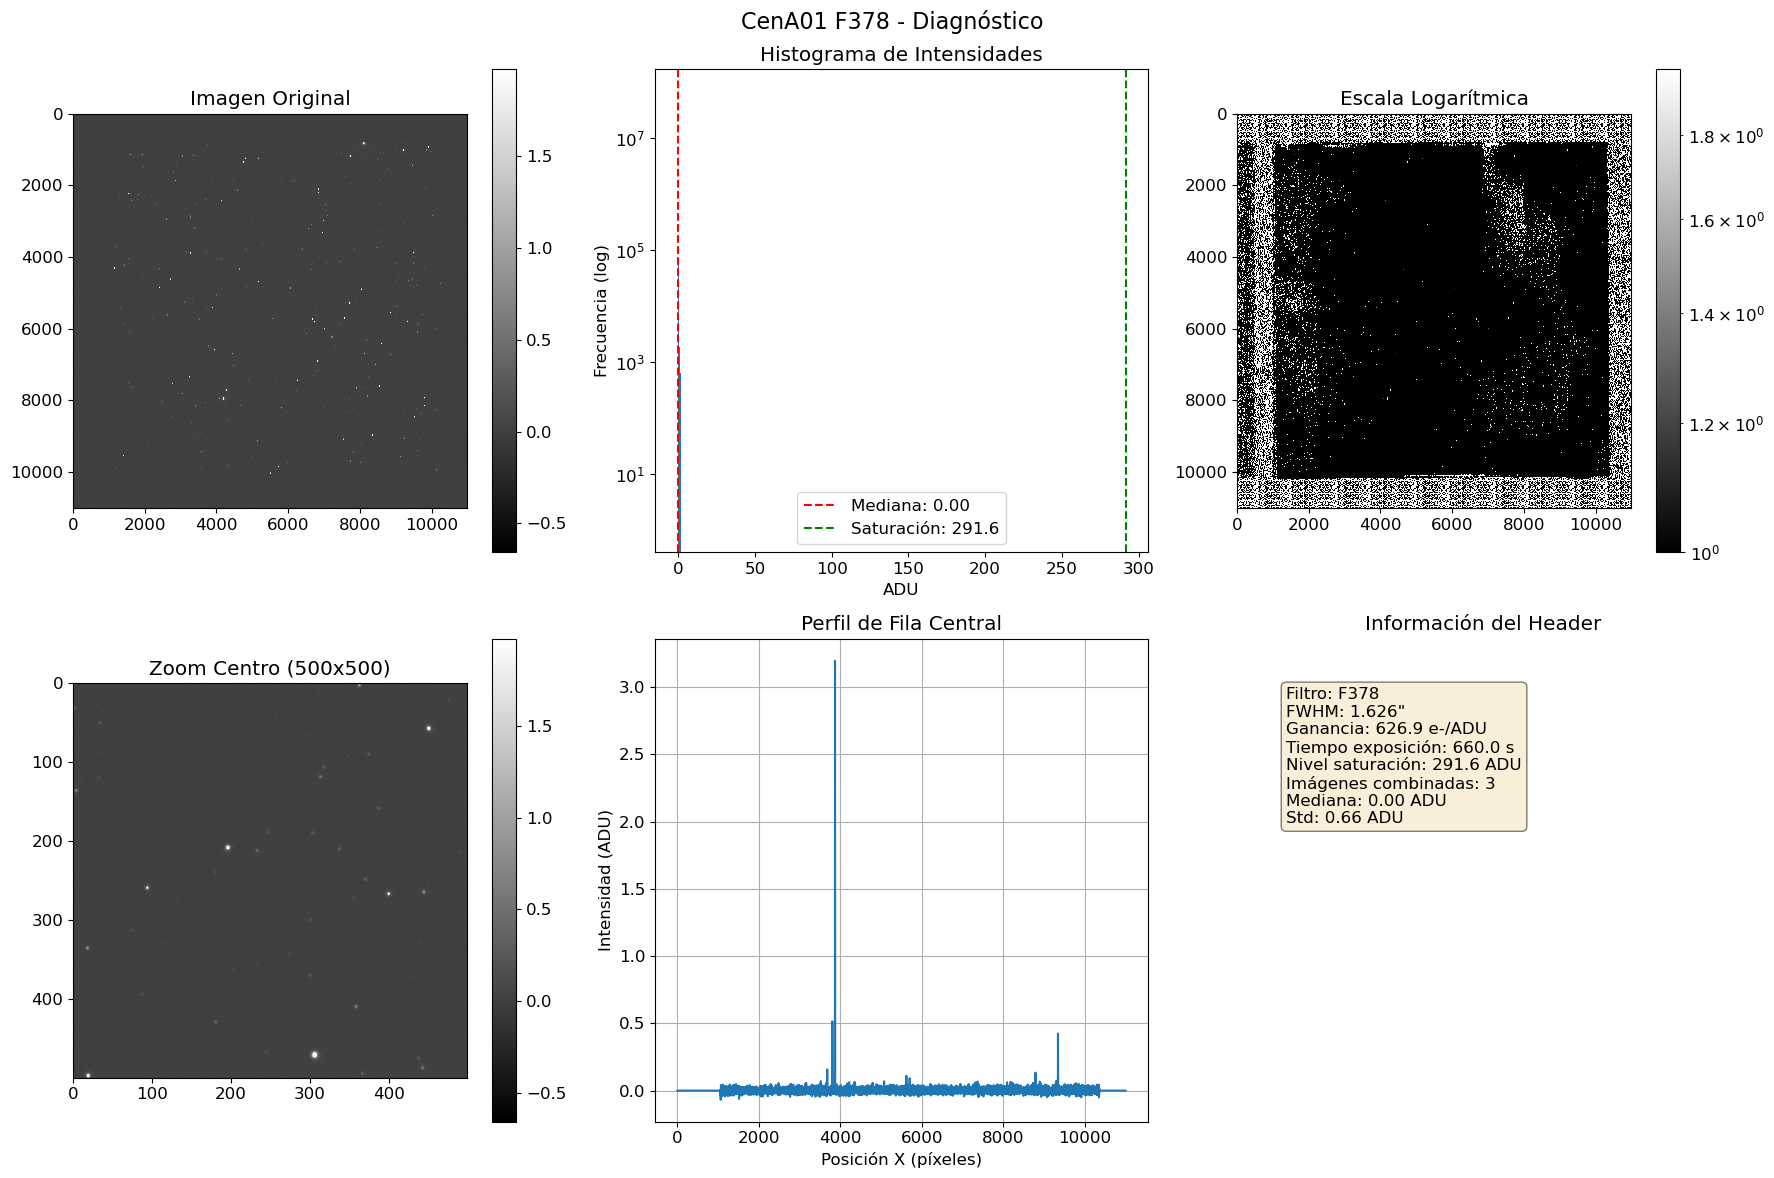

2025-09-20 16:35:41,981 [INFO] Analizando CenA01 F395


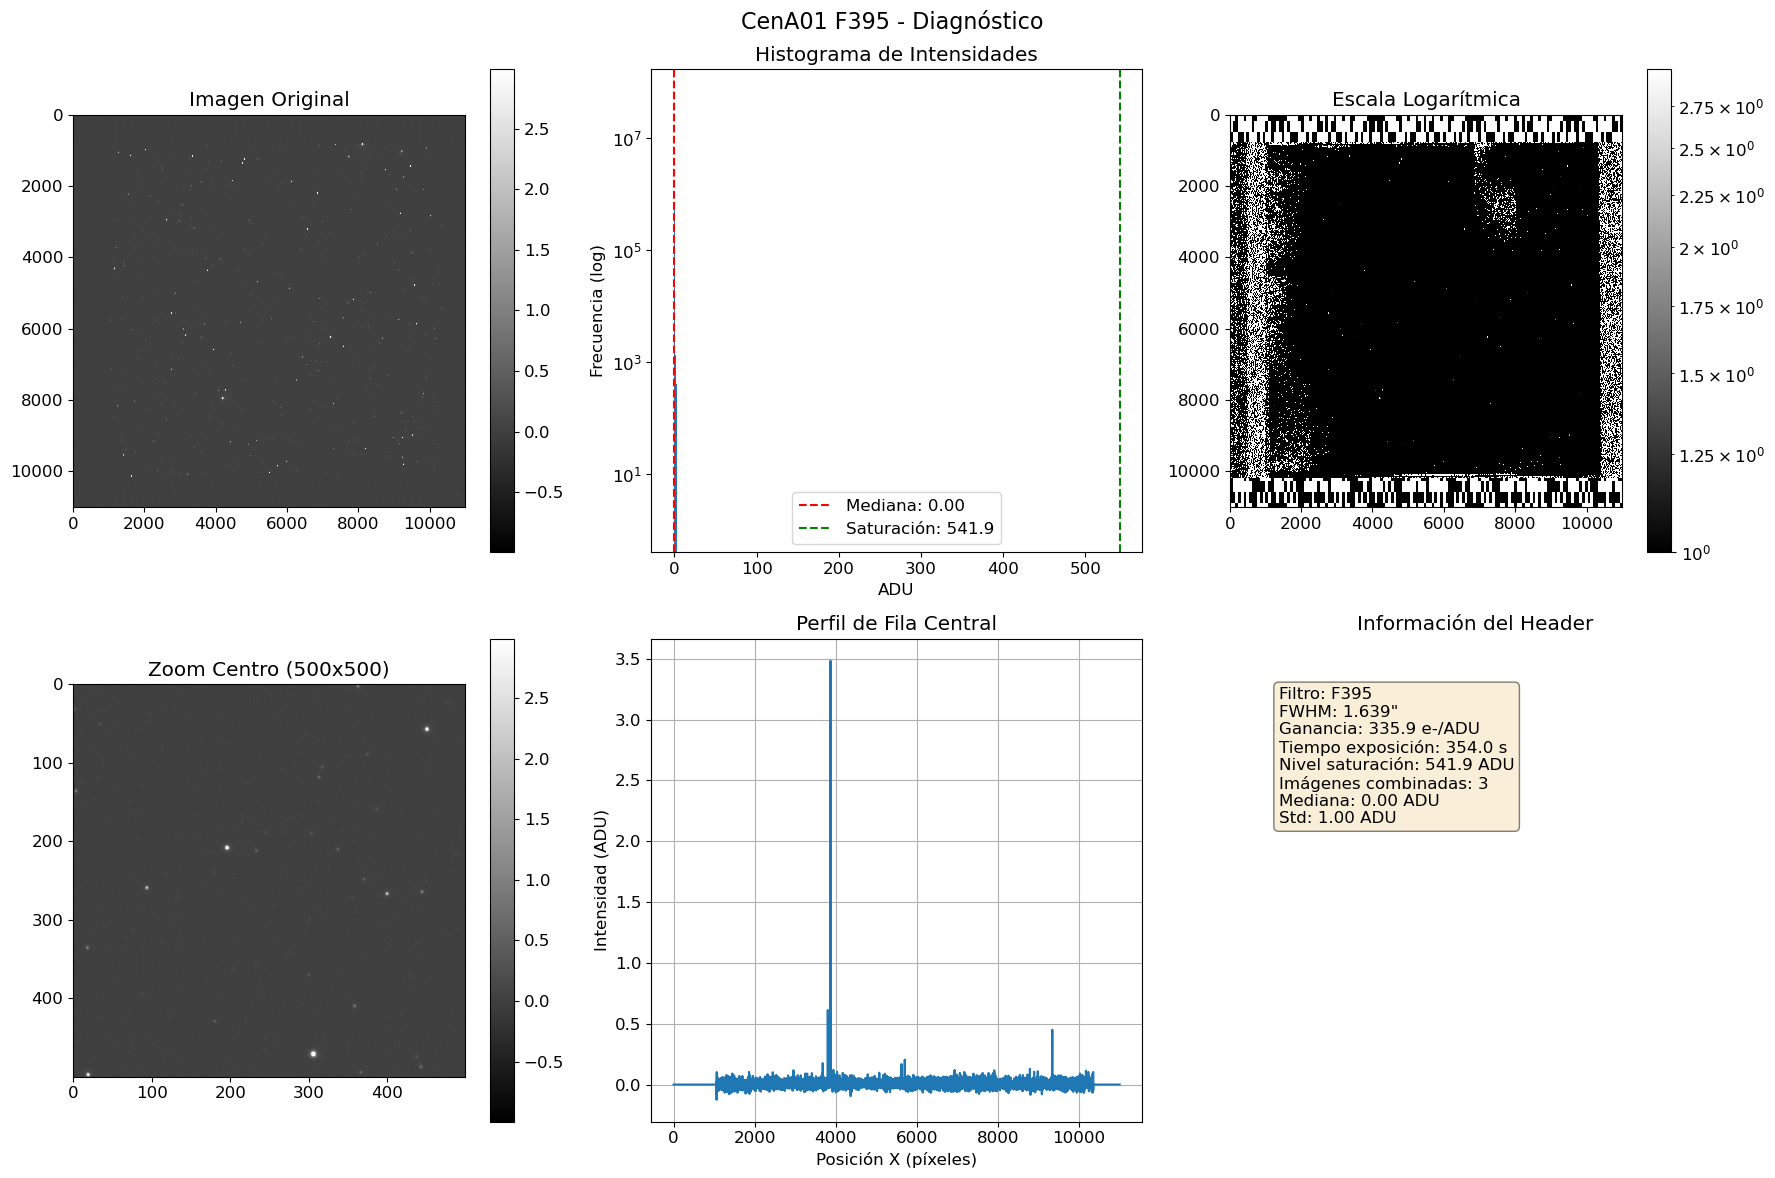

2025-09-20 16:36:20,326 [INFO] Analizando CenA01 F410


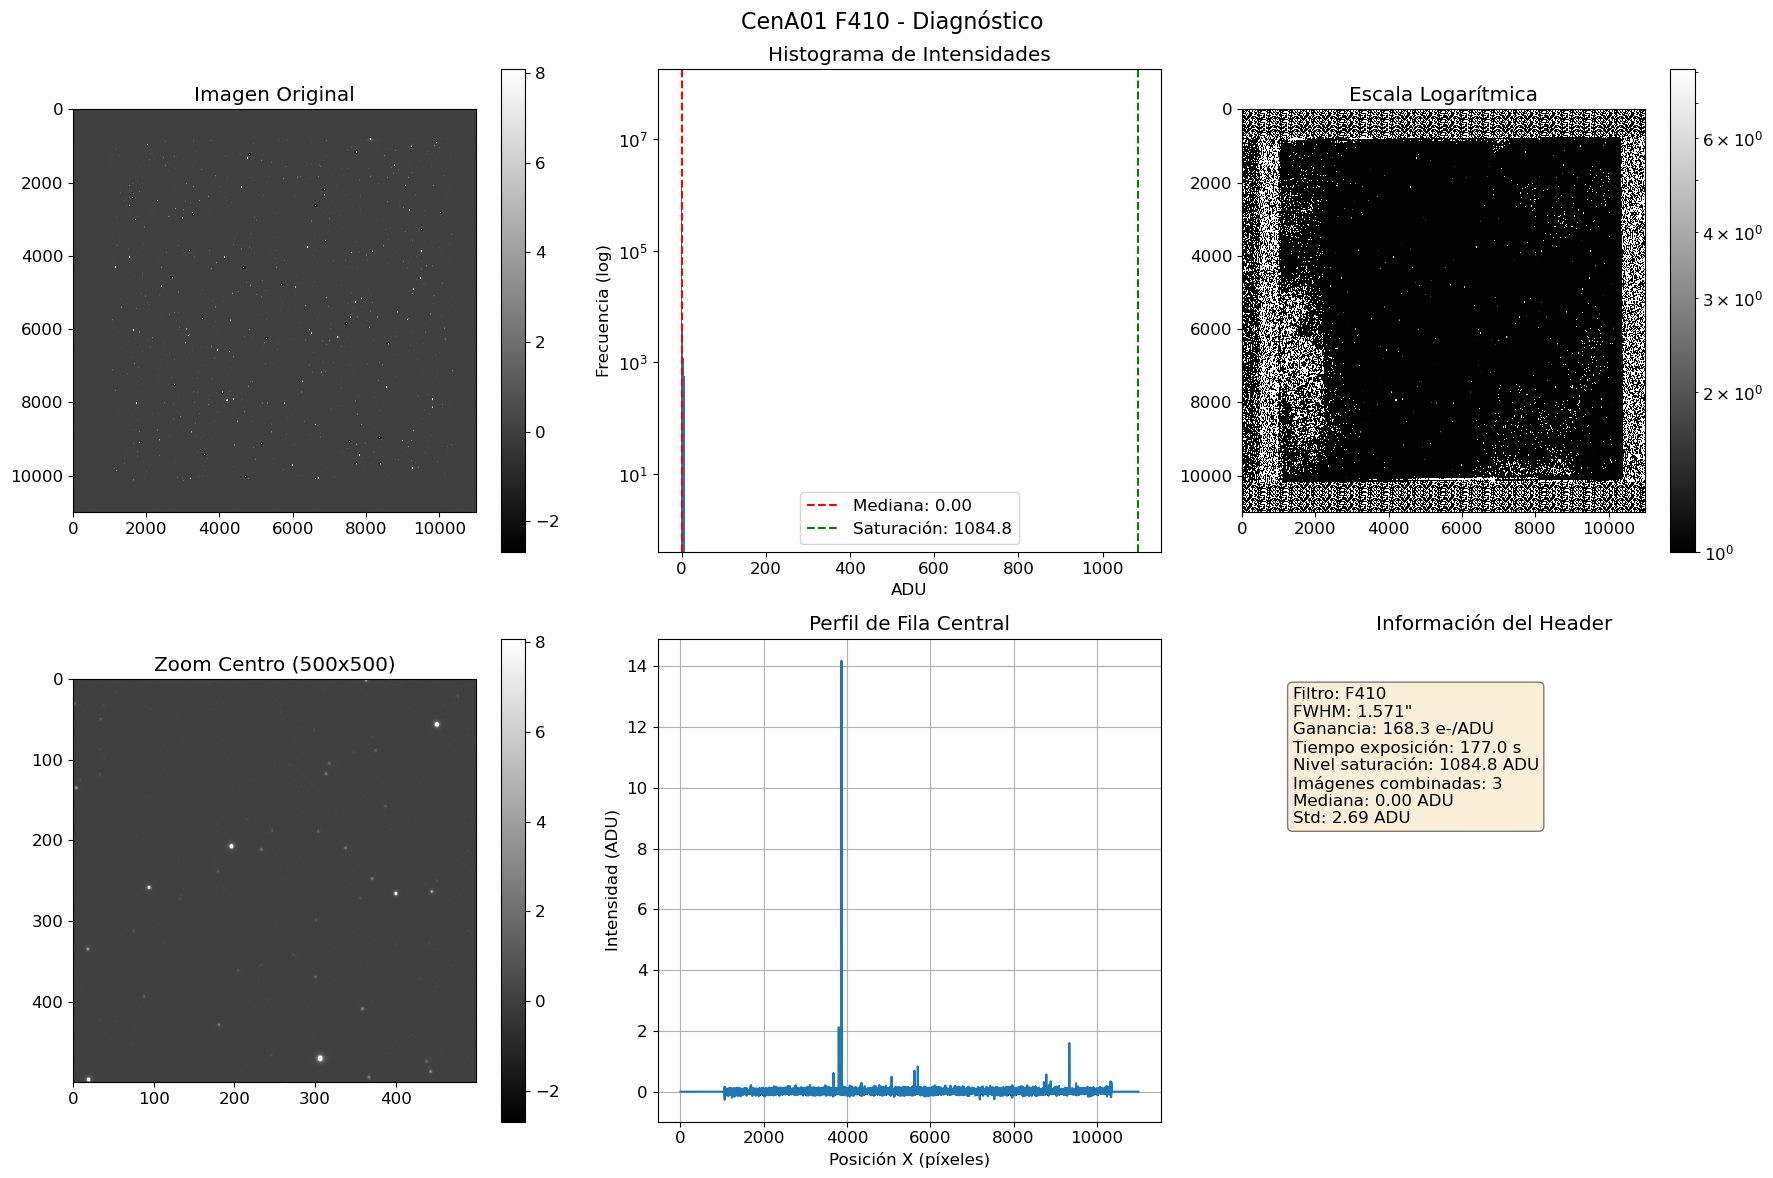

2025-09-20 16:36:56,261 [INFO] Analizando CenA01 F430


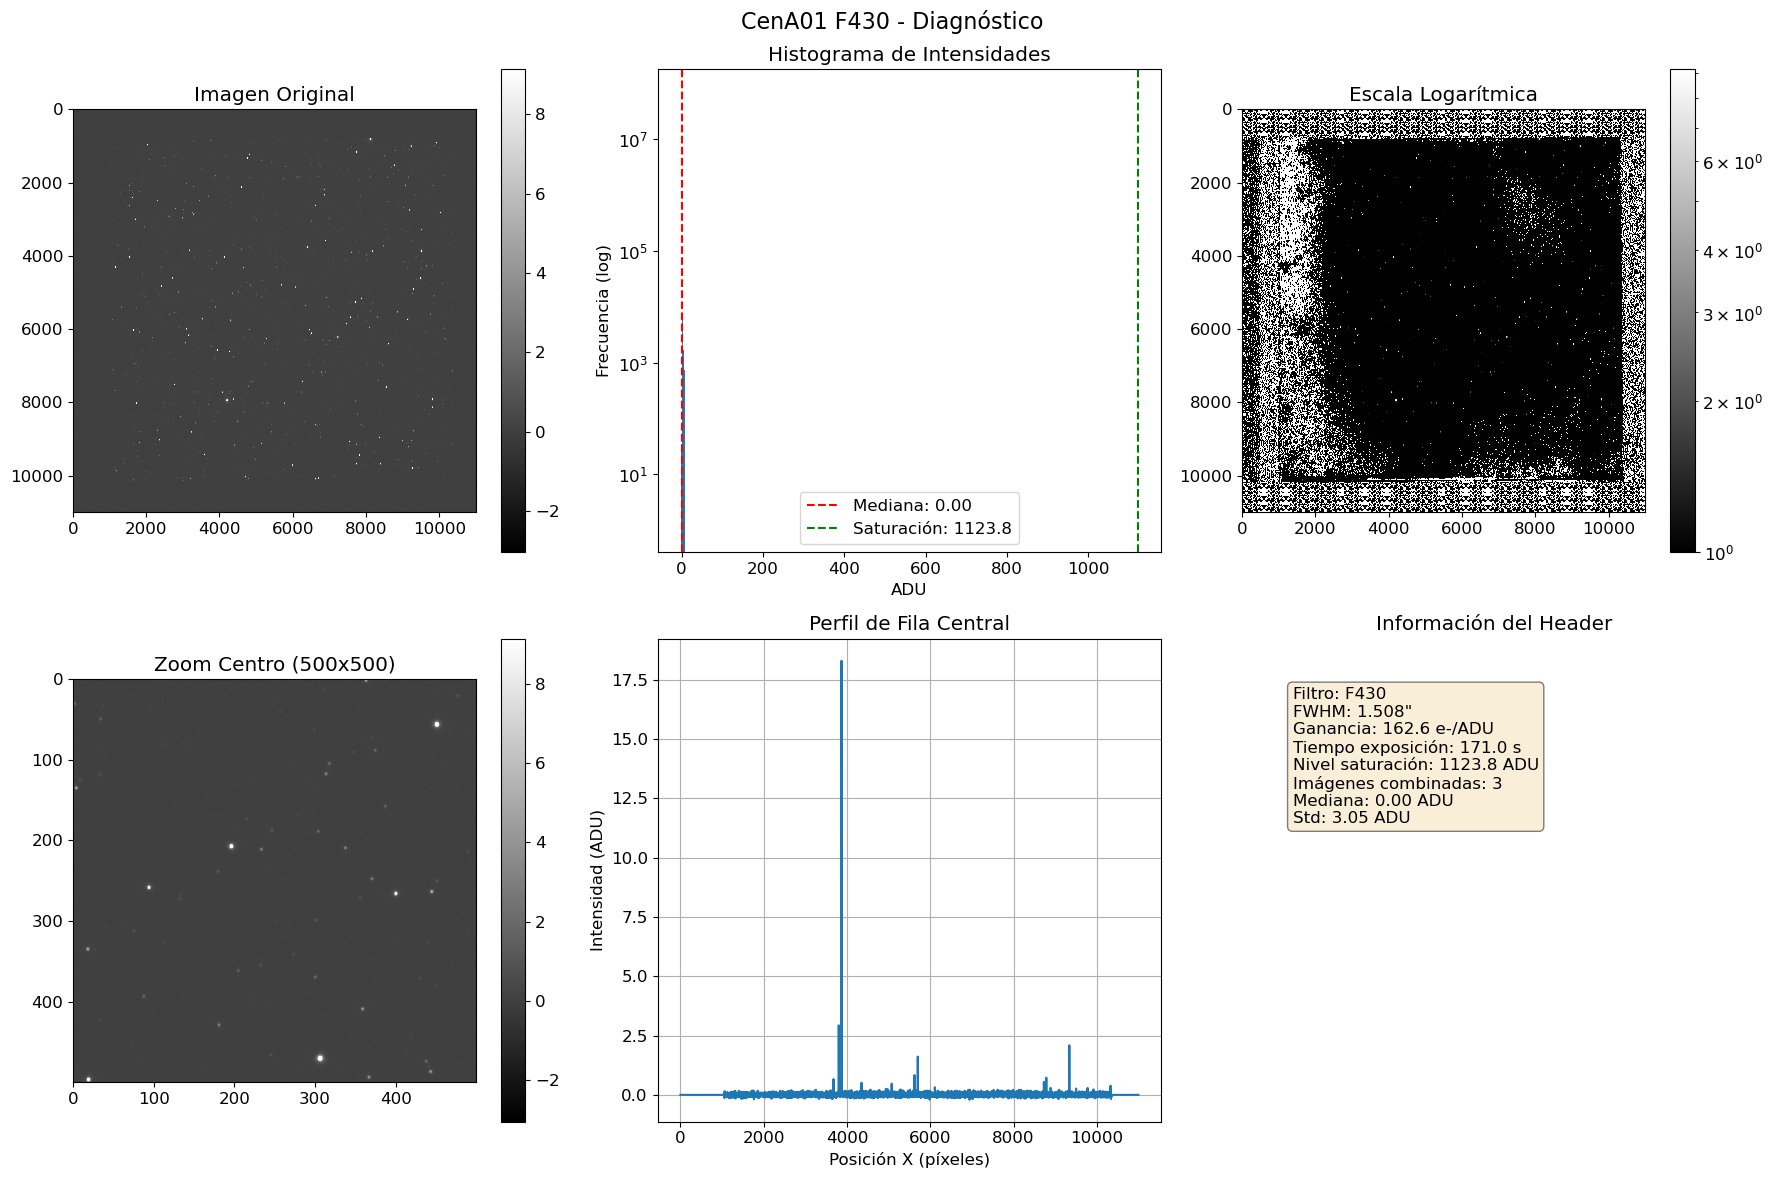

2025-09-20 16:37:31,874 [INFO] Analizando CenA01 F515


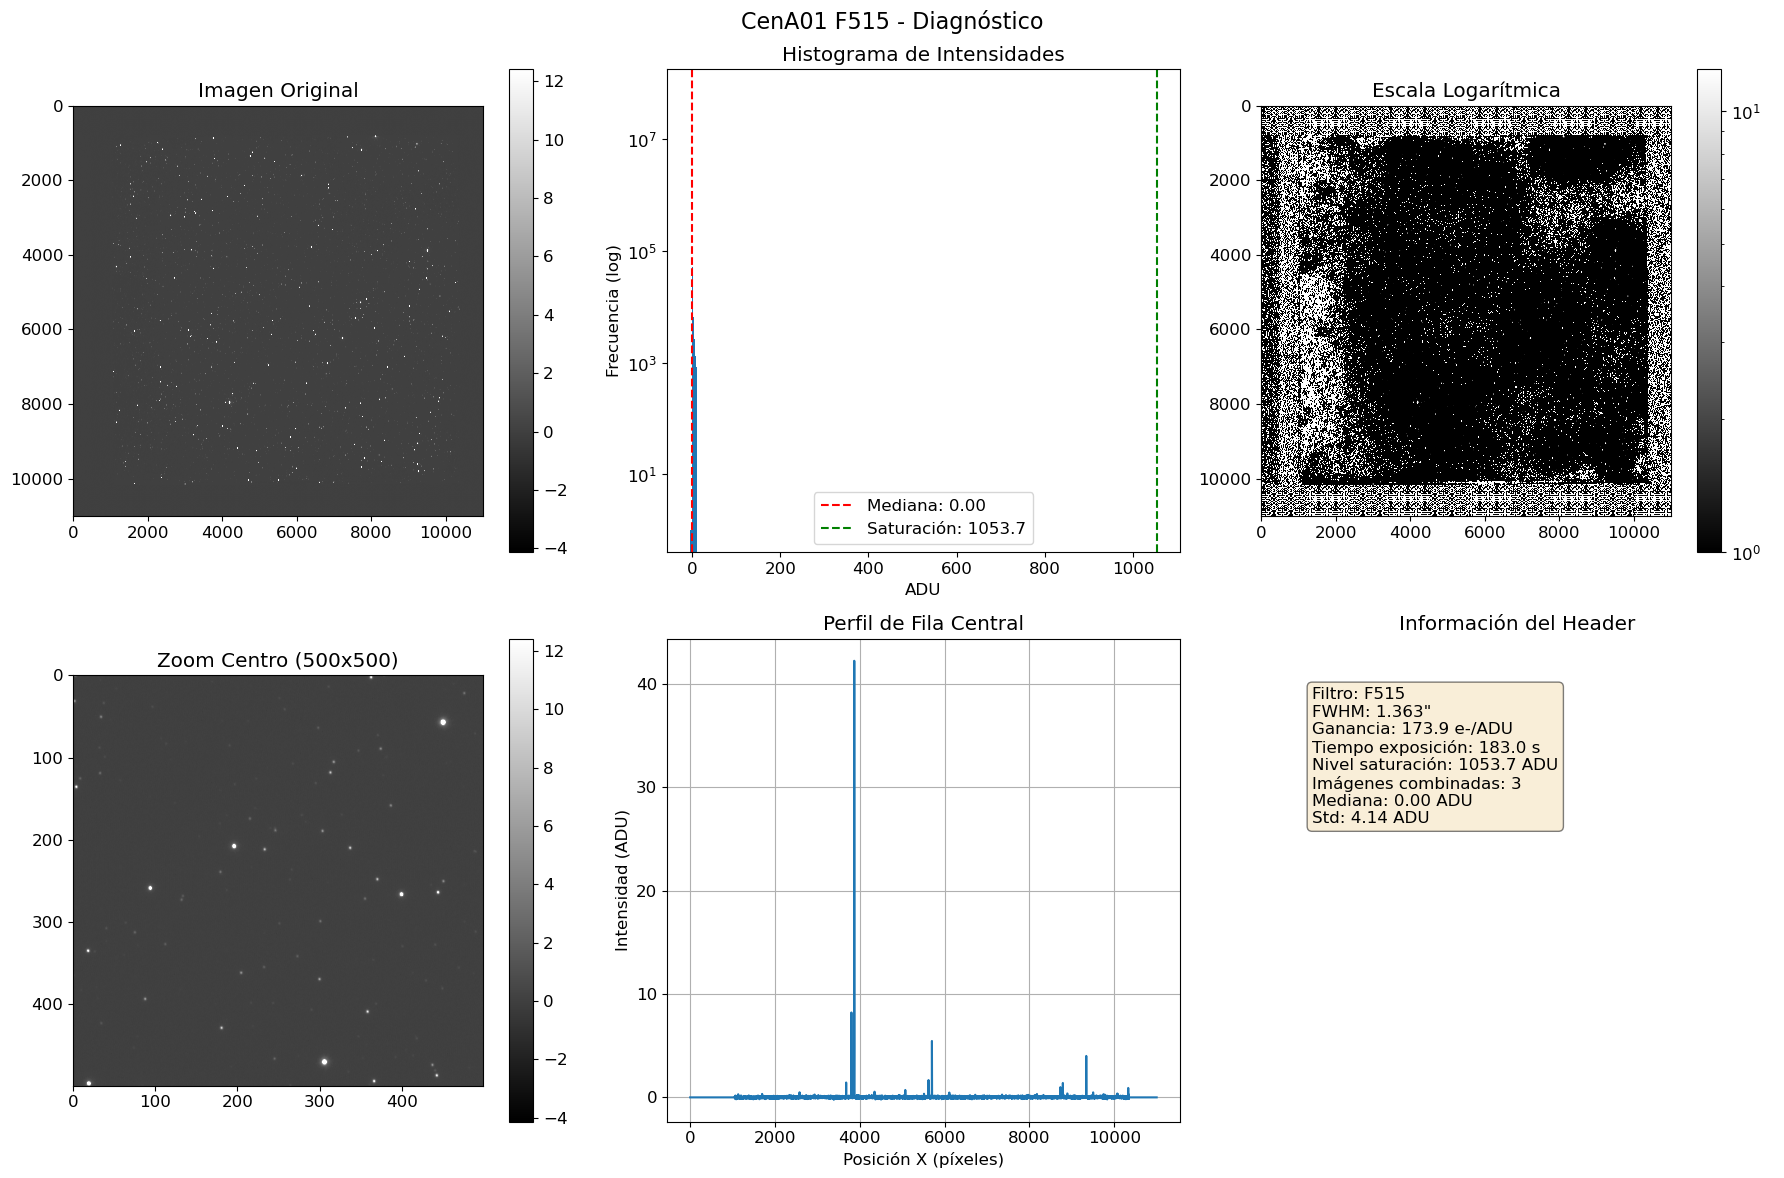

2025-09-20 16:38:07,564 [INFO] Analizando CenA01 F660


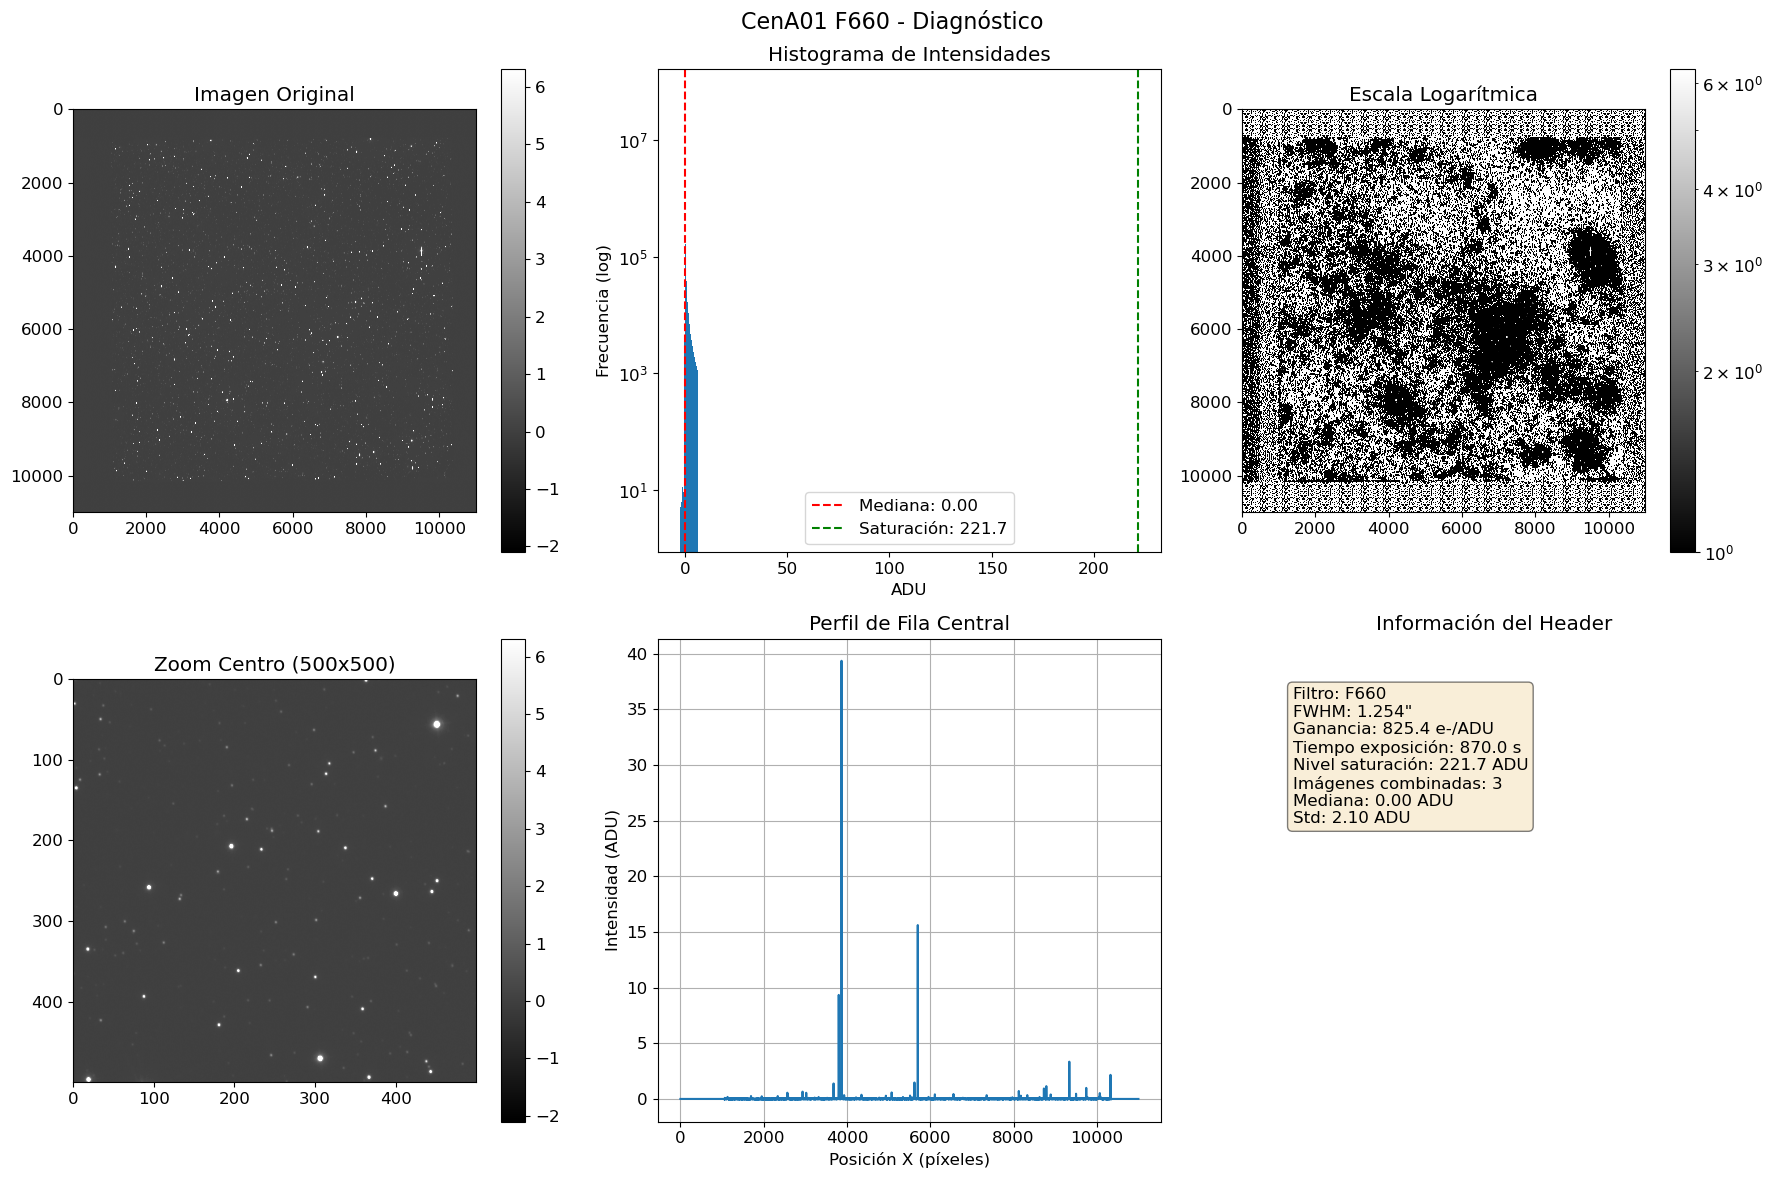

2025-09-20 16:38:43,302 [INFO] Analizando CenA01 F861


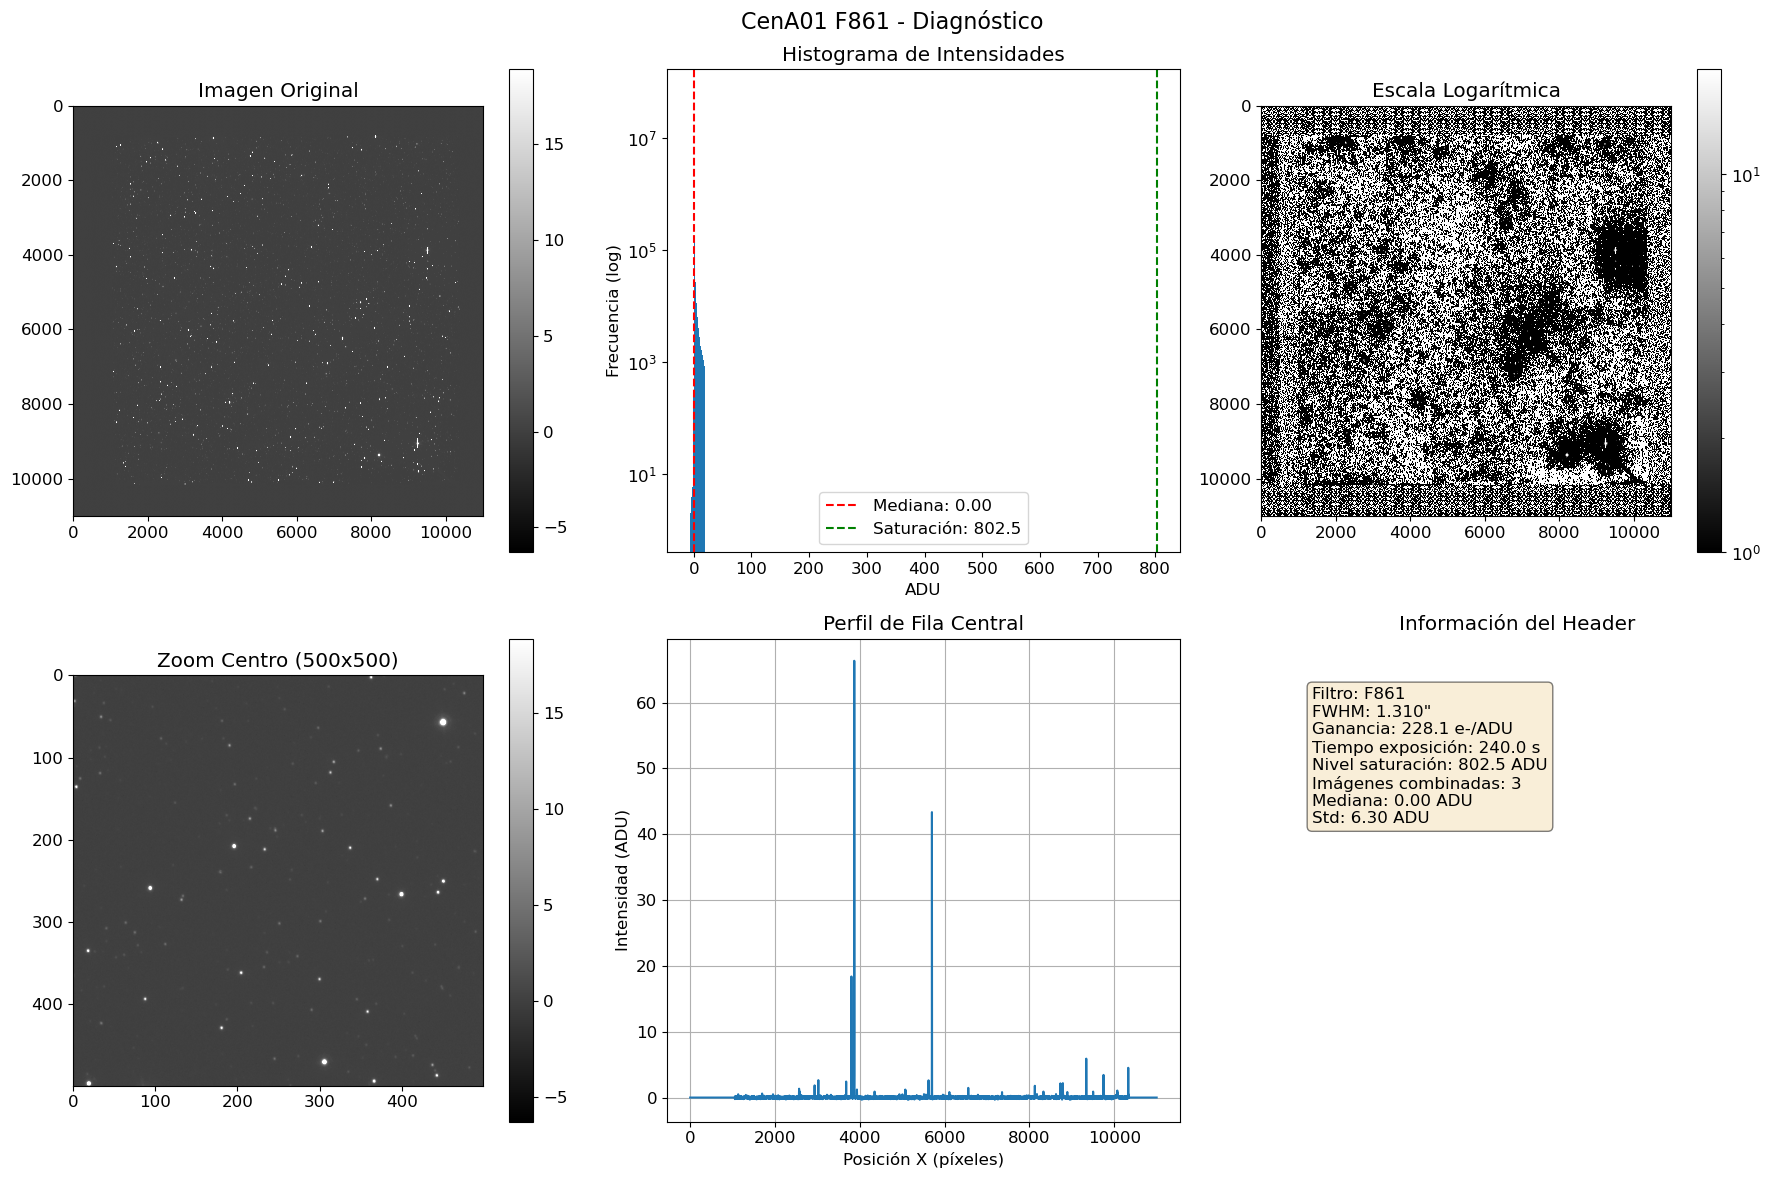


Resumen para CenA01:
          fwhm        gain  exptime  median       std
F378  1.626466  626.928875    660.0     0.0  0.658149
F395  1.638681  335.917120    354.0     0.0  0.996695
F410  1.570536  168.339343    177.0     0.0  2.693487
F430  1.508293  162.626643    171.0     0.0  3.046373
F515  1.362559  173.851965    183.0     0.0  4.136719
F660  1.254116  825.352071    870.0     0.0  2.103072
F861  1.310045  228.055904    240.0     0.0  6.295103


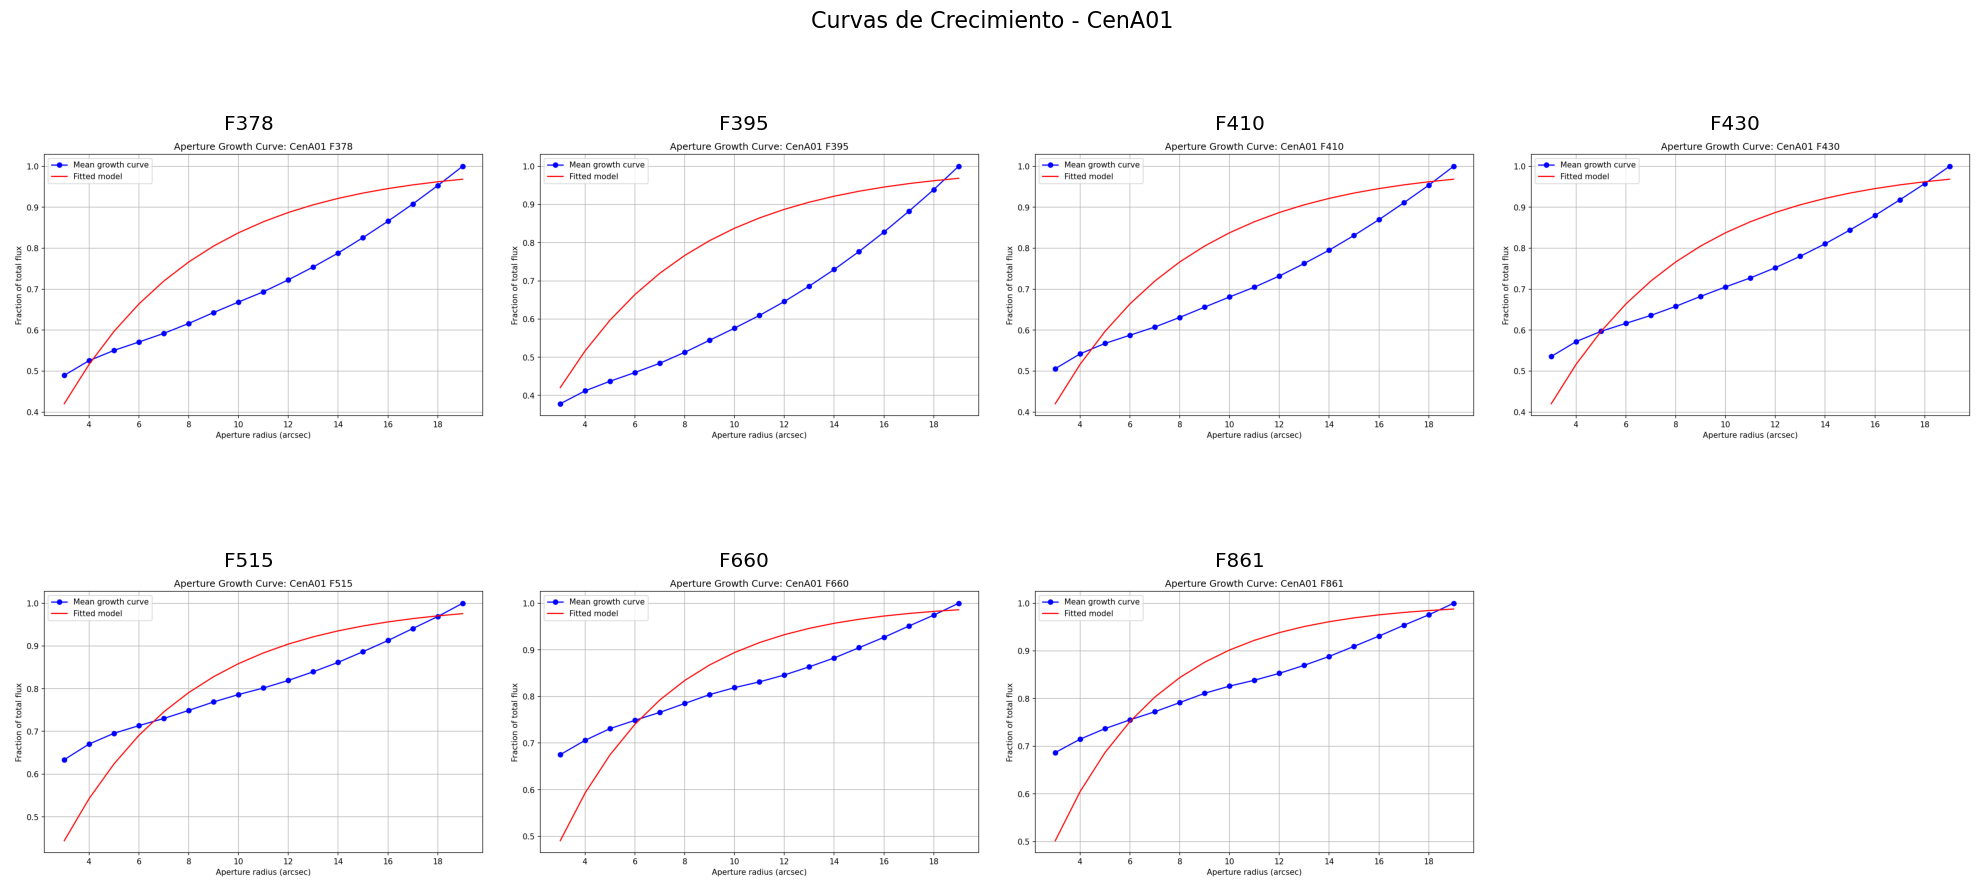

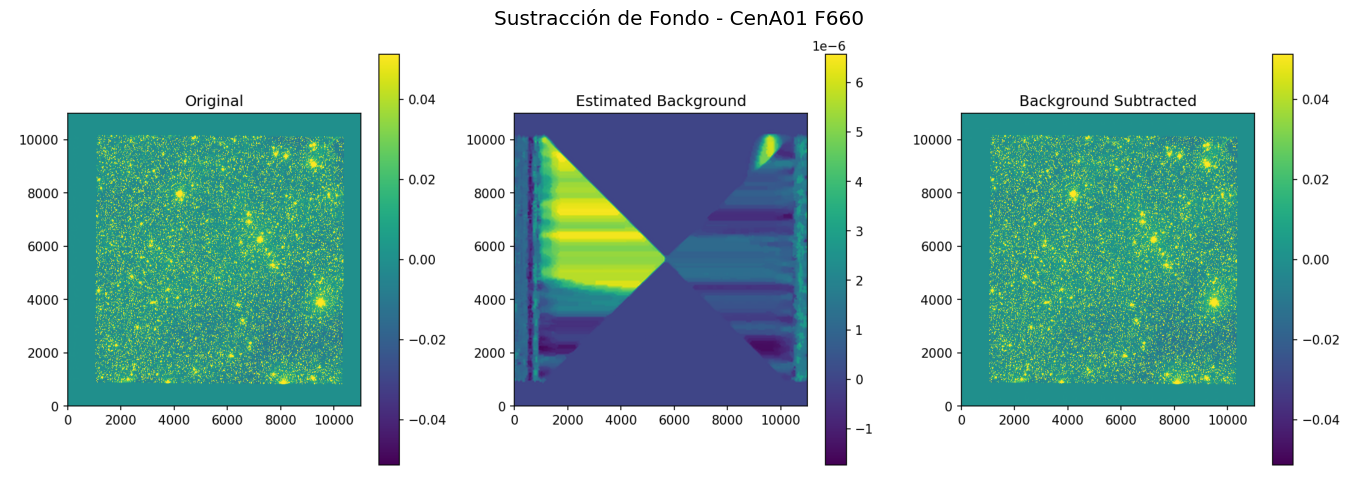

=== RECOMENDACIONES ===
✅ FWHM consistente entre filtros: 1.467 ± 0.145
✅ F378: Buen rango dinámico (mediana: 0.0 ADU, saturación: 291.6 ADU)
✅ F395: Buen rango dinámico (mediana: 0.0 ADU, saturación: 541.9 ADU)
✅ F410: Buen rango dinámico (mediana: 0.0 ADU, saturación: 1084.8 ADU)
✅ F430: Buen rango dinámico (mediana: 0.0 ADU, saturación: 1123.8 ADU)
✅ F515: Buen rango dinámico (mediana: 0.0 ADU, saturación: 1053.7 ADU)
✅ F660: Buen rango dinámico (mediana: 0.0 ADU, saturación: 221.7 ADU)
✅ F861: Buen rango dinámico (mediana: 0.0 ADU, saturación: 802.5 ADU)
❌ Valores de ganancia inusualmente altos: [626.92887451 335.91712034 168.33934319 162.62664297 173.85196524
 825.35207124 228.05590391]
   Esto podría indicar un problema con las unidades de flujo


In [13]:
# Celda 1: Configuración inicial
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

# Configurar estilo de plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Celda 2: Función para analizar imágenes
def analyze_splus_image(field_name, filter_name, base_path="../anac_data"):
    """
    Analiza una imagen SPLUS y extrae información clave del header
    """
    image_path = os.path.join(base_path, field_name, f"{field_name}_{filter_name}.fits.fz")
    
    if not os.path.exists(image_path):
        logging.warning(f"Imagen no encontrada: {image_path}")
        return None
    
    try:
        with fits.open(image_path) as hdul:
            if len(hdul) > 1 and hdul[1].data is not None:
                data = hdul[1].data.astype(float)
                header = hdul[1].header
            else:
                data = hdul[0].data.astype(float)
                header = hdul[0].header
        
        # Extraer información clave del header
        info = {
            'filter': filter_name,
            'fwhm': header.get('FWHMMEAN', 1.5),
            'gain': header.get('GAIN', 1.0),
            'exptime': header.get('EXPTIME', 1.0),
            'saturate': header.get('SATURATE', 100000),
            'pixscale': header.get('PIXSCALE', 0.55),
            'ncombine': header.get('NCOMBINE', 1),
            'mean': np.nanmean(data),
            'median': np.nanmedian(data),
            'std': np.nanstd(data),
            'max': np.nanmax(data),
            'min': np.nanmin(data)
        }
        
        return data, header, info
        
    except Exception as e:
        logging.error(f"Error analizando {image_path}: {e}")
        return None, None, None

# Celda 3: Función para visualizar imágenes
def plot_image_diagnostics(field_name, filter_name, data, info):
    """
    Crea visualizaciones diagnósticas para una imagen
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{field_name} {filter_name} - Diagnóstico', fontsize=16)
    
    # Panel 1: Imagen original
    vmin = info['median'] - info['std']
    vmax = info['median'] + 3 * info['std']
    im1 = axes[0, 0].imshow(data, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0, 0].set_title('Imagen Original')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Panel 2: Histograma
    axes[0, 1].hist(data.flatten(), bins=100, range=(vmin, vmax), log=True)
    axes[0, 1].axvline(info['median'], color='r', linestyle='--', label=f'Mediana: {info["median"]:.2f}')
    axes[0, 1].axvline(info['saturate'], color='g', linestyle='--', label=f'Saturación: {info["saturate"]:.1f}')
    axes[0, 1].set_xlabel('ADU')
    axes[0, 1].set_ylabel('Frecuencia (log)')
    axes[0, 1].legend()
    axes[0, 1].set_title('Histograma de Intensidades')
    
    # Panel 3: Imagen con escala logarítmica
    im3 = axes[0, 2].imshow(data, cmap='gray', norm=LogNorm(vmin=max(1, vmin), vmax=vmax))
    axes[0, 2].set_title('Escala Logarítmica')
    plt.colorbar(im3, ax=axes[0, 2])
    
    # Panel 4: Zoom a una región central (500x500 píxeles)
    height, width = data.shape
    center_y, center_x = height // 2, width // 2
    zoom_size = 500
    y_start = max(0, center_y - zoom_size // 2)
    y_end = min(height, center_y + zoom_size // 2)
    x_start = max(0, center_x - zoom_size // 2)
    x_end = min(width, center_x + zoom_size // 2)
    
    zoom_data = data[y_start:y_end, x_start:x_end]
    im4 = axes[1, 0].imshow(zoom_data, cmap='gray', vmin=vmin, vmax=vmax)
    axes[1, 0].set_title(f'Zoom Centro ({zoom_size}x{zoom_size})')
    plt.colorbar(im4, ax=axes[1, 0])
    
    # Panel 5: Perfil de fila central
    row_profile = data[center_y, :]
    axes[1, 1].plot(row_profile)
    axes[1, 1].set_xlabel('Posición X (píxeles)')
    axes[1, 1].set_ylabel('Intensidad (ADU)')
    axes[1, 1].set_title('Perfil de Fila Central')
    axes[1, 1].grid(True)
    
    # Panel 6: Información del header
    textstr = '\n'.join((
        f'Filtro: {info["filter"]}',
        f'FWHM: {info["fwhm"]:.3f}"',
        f'Ganancia: {info["gain"]:.1f} e-/ADU',
        f'Tiempo exposición: {info["exptime"]:.1f} s',
        f'Nivel saturación: {info["saturate"]:.1f} ADU',
        f'Imágenes combinadas: {info["ncombine"]}',
        f'Mediana: {info["median"]:.2f} ADU',
        f'Std: {info["std"]:.2f} ADU'
    ))
    
    axes[1, 2].text(0.1, 0.9, textstr, transform=axes[1, 2].transAxes, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 2].set_axis_off()
    axes[1, 2].set_title('Información del Header')
    
    plt.tight_layout()
    plt.savefig(f'{field_name}_{filter_name}_diagnostic.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# Celda 4: Análisis de todas las imágenes de un campo
def analyze_all_filters(field_name, filters=['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']):
    """
    Analiza todas las imágenes de filtros para un campo dado
    """
    results = {}
    
    for filter_name in filters:
        logging.info(f"Analizando {field_name} {filter_name}")
        data, header, info = analyze_splus_image(field_name, filter_name)
        
        if data is not None:
            results[filter_name] = info
            fig = plot_image_diagnostics(field_name, filter_name, data, info)
            plt.close(fig)  # Cerrar figura para evitar sobrecarga de memoria
    
    # Crear resumen comparativo
    summary_df = pd.DataFrame.from_dict(results, orient='index')
    print(f"\nResumen para {field_name}:")
    print(summary_df[['fwhm', 'gain', 'exptime', 'median', 'std']])
    
    return summary_df

# Celda 5: Ejecutar análisis para CenA01
field_name = "CenA01"
filters = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

summary = analyze_all_filters(field_name, filters)

# Celda 6: Análisis de curvas de crecimiento (si están disponibles)
def analyze_growth_curves(field_name, filters, base_path="../anac_data"):
    """
    Analiza las curvas de crecimiento generadas por el script
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, filter_name in enumerate(filters):
        if i >= len(axes):
            break
            
        curve_path = os.path.join(base_path, f"{field_name}_{filter_name}_growth_curve.png")
        
        if os.path.exists(curve_path):
            img = plt.imread(curve_path)
            axes[i].imshow(img)
            axes[i].set_title(f'{filter_name}')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'No hay curva de crecimiento\npara {filter_name}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{filter_name} (no disponible)')
            axes[i].axis('off')
    
    # Ocultar ejes extra
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle(f'Curvas de Crecimiento - {field_name}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{field_name}_growth_curves_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

# Ejecutar análisis de curvas de crecimiento
analyze_growth_curves(field_name, filters)

# Celda 7: Análisis de imágenes de fondo (si están disponibles)
def analyze_background_images(field_name, filters, base_path="../anac_data"):
    """
    Analiza las imágenes de sustracción de fondo generadas por el script
    """
    for filter_name in filters:
        bg_path = os.path.join(base_path, f"{field_name}_{filter_name}_background_subtraction.png")
        
        if os.path.exists(bg_path):
            img = plt.imread(bg_path)
            plt.figure(figsize=(15, 5))
            plt.imshow(img)
            plt.title(f'Sustracción de Fondo - {field_name} {filter_name}')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

# Ejecutar análisis de imágenes de fondo
analyze_background_images(field_name, filters)

# Celda 8: Recomendaciones basadas en el análisis
def generate_recommendations(summary_df):
    """
    Genera recomendaciones basadas en el análisis de las imágenes
    """
    print("=== RECOMENDACIONES ===")
    
    # Verificar consistencia de FWHM
    fwhm_values = summary_df['fwhm'].values
    if np.std(fwhm_values) > 0.2:
        print(f"❌ Gran variación en FWHM entre filtros: {fwhm_values}")
        print("   Esto podría indicar problemas con la calidad de imagen o el cálculo de FWHM")
    else:
        print(f"✅ FWHM consistente entre filtros: {np.mean(fwhm_values):.3f} ± {np.std(fwhm_values):.3f}")
    
    # Verificar niveles de saturación
    median_values = summary_df['median'].values
    saturate_values = summary_df['saturate'].values
    
    for i, (filt, median, saturate) in enumerate(zip(summary_df.index, median_values, saturate_values)):
        saturation_ratio = median / saturate
        if saturation_ratio > 0.1:
            print(f"❌ {filt}: Nivel mediano ({median:.1f} ADU) es >10% del nivel de saturación ({saturate:.1f} ADU)")
        else:
            print(f"✅ {filt}: Buen rango dinámico (mediana: {median:.1f} ADU, saturación: {saturate:.1f} ADU)")
    
    # Verificar ganancia
    gain_values = summary_df['gain'].values
    if np.any(gain_values > 100):
        print(f"❌ Valores de ganancia inusualmente altos: {gain_values}")
        print("   Esto podría indicar un problema con las unidades de flujo")
    else:
        print(f"✅ Valores de ganancia normales: {np.mean(gain_values):.1f} ± {np.std(gain_values):.1f} e-/ADU")

# Generar recomendaciones
generate_recommendations(summary)

## Other script


=== ANÁLISIS PROFUNDO: CenA01 F660 ===
Número de extensiones: 2

--- Extensión 0 ---
  Tipo: PrimaryHDU
  Forma: No data
  Algunas claves del header:
    BITPIX: 16
    NAXIS: 0

--- Extensión 1 ---
  Tipo: CompImageHDU
  Forma: (11000, 11000)
  Tipo de datos: float32
  Min: -58.627
  Max: 310.432
  Mediana: 0.000
  Media: 0.047
  Std: 2.103
  Ceros: 18370000 (15.18%)
  NaNs: 0 (0.00%)
  Negativos: 48316441 (39.93%)


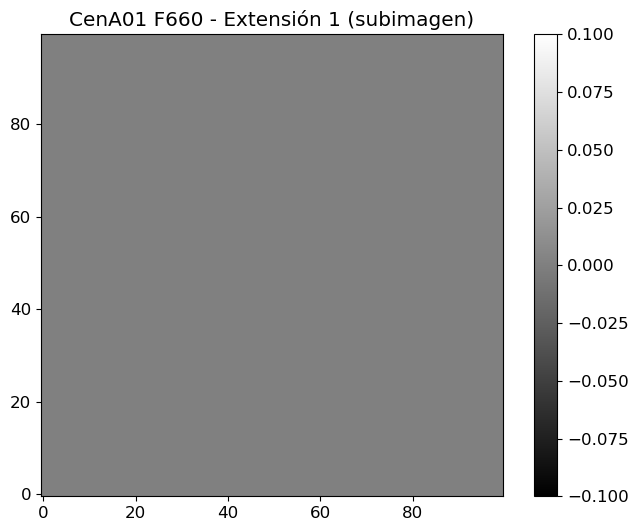

  Algunas claves del header:
    BITPIX: -32
    NAXIS: 2
    NAXIS1: 11000
    NAXIS2: 11000

=== ANÁLISIS PROFUNDO: CenA01 F861 ===
Número de extensiones: 2

--- Extensión 0 ---
  Tipo: PrimaryHDU
  Forma: No data
  Algunas claves del header:
    BITPIX: 16
    NAXIS: 0

--- Extensión 1 ---
  Tipo: CompImageHDU
  Forma: (11000, 11000)
  Tipo de datos: float32
  Min: -168.647
  Max: 1092.444
  Mediana: 0.000
  Media: 0.118
  Std: 6.295
  Ceros: 18381000 (15.19%)
  NaNs: 0 (0.00%)
  Negativos: 48699287 (40.25%)


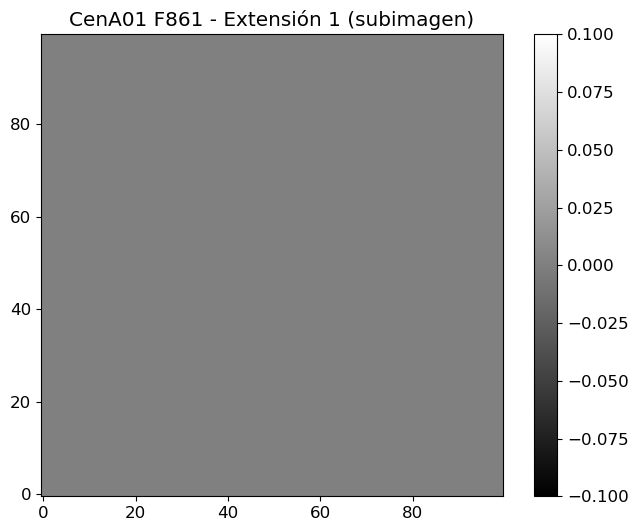

  Algunas claves del header:
    BITPIX: -32
    NAXIS: 2
    NAXIS1: 11000
    NAXIS2: 11000

=== ANÁLISIS PROFUNDO: CenA01 F515 ===
Número de extensiones: 2

--- Extensión 0 ---
  Tipo: PrimaryHDU
  Forma: No data
  Algunas claves del header:
    BITPIX: 16
    NAXIS: 0

--- Extensión 1 ---
  Tipo: CompImageHDU
  Forma: (11000, 11000)
  Tipo de datos: float32
  Min: -147.184
  Max: 1384.088
  Mediana: 0.000
  Media: 0.057
  Std: 4.137
  Ceros: 18392000 (15.20%)
  NaNs: 0 (0.00%)
  Negativos: 45667513 (37.74%)


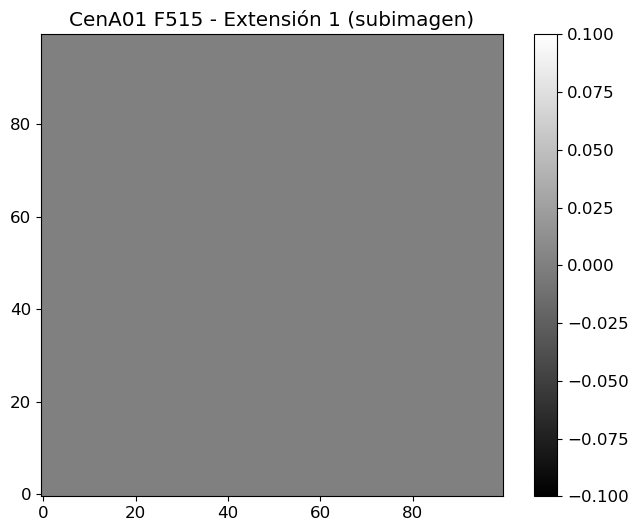

  Algunas claves del header:
    BITPIX: -32
    NAXIS: 2
    NAXIS1: 11000
    NAXIS2: 11000


In [14]:
# Celda de diagnóstico urgente - Verificar imágenes reales
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os

def deep_image_analysis(field_name, filter_name):
    image_path = f"../anac_data/{field_name}/{field_name}_{filter_name}.fits.fz"
    
    print(f"\n=== ANÁLISIS PROFUNDO: {field_name} {filter_name} ===")
    
    if not os.path.exists(image_path):
        print(f"❌ Archivo no encontrado: {image_path}")
        return
    
    try:
        with fits.open(image_path) as hdul:
            print(f"Número de extensiones: {len(hdul)}")
            
            # Mostrar información de cada extensión
            for i, hdu in enumerate(hdul):
                print(f"\n--- Extensión {i} ---")
                print(f"  Tipo: {type(hdu).__name__}")
                print(f"  Forma: {hdu.data.shape if hasattr(hdu, 'data') and hdu.data is not None else 'No data'}")
                
                if hasattr(hdu, 'data') and hdu.data is not None:
                    data = hdu.data
                    print(f"  Tipo de datos: {data.dtype}")
                    
                    # Estadísticas básicas
                    print(f"  Min: {np.nanmin(data):.3f}")
                    print(f"  Max: {np.nanmax(data):.3f}")
                    print(f"  Mediana: {np.nanmedian(data):.3f}")
                    print(f"  Media: {np.nanmean(data):.3f}")
                    print(f"  Std: {np.nanstd(data):.3f}")
                    
                    # Verificar valores especiales
                    zeros = np.sum(data == 0)
                    nans = np.sum(np.isnan(data))
                    negatives = np.sum(data < 0)
                    total = data.size
                    
                    print(f"  Ceros: {zeros} ({zeros/total*100:.2f}%)")
                    print(f"  NaNs: {nans} ({nans/total*100:.2f}%)")
                    print(f"  Negativos: {negatives} ({negatives/total*100:.2f}%)")
                    
                    # Mostrar una pequeña subimagen para diagnóstico
                    if data.ndim == 2 and data.shape[0] > 100 and data.shape[1] > 100:
                        sub_data = data[100:200, 100:200]  # 100x100 subimage
                        plt.figure(figsize=(8, 6))
                        plt.imshow(sub_data, cmap='gray', origin='lower')
                        plt.colorbar()
                        plt.title(f'{field_name} {filter_name} - Extensión {i} (subimagen)')
                        plt.show()
                
                # Mostrar algunas claves del header si existe
                if hasattr(hdu, 'header') and hdu.header is not None:
                    print("  Algunas claves del header:")
                    for key in ['BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'BSCALE', 'BZERO']:
                        if key in hdu.header:
                            print(f"    {key}: {hdu.header[key]}")
                    
    except Exception as e:
        print(f"❌ Error al leer {image_path}: {e}")

# Ejecutar para varios filtros
for filter_name in ['F660', 'F861', 'F515']:
    deep_image_analysis("CenA01", filter_name)


=== CenA01 F660 ===
Mediana: 0.000
Media: 0.047
Std: 2.103
Mínimo: -58.627
Máximo: 310.432

Fotometría de prueba:
Posición [5500, 5500]: Flux = -0.061
  Flujo no positivo - no se puede calcular magnitud
Posición [6000, 6000]: Flux = 0.487
  Magnitud aproximada: 25.78
Posición [5000, 5000]: Flux = -0.469
  Flujo no positivo - no se puede calcular magnitud


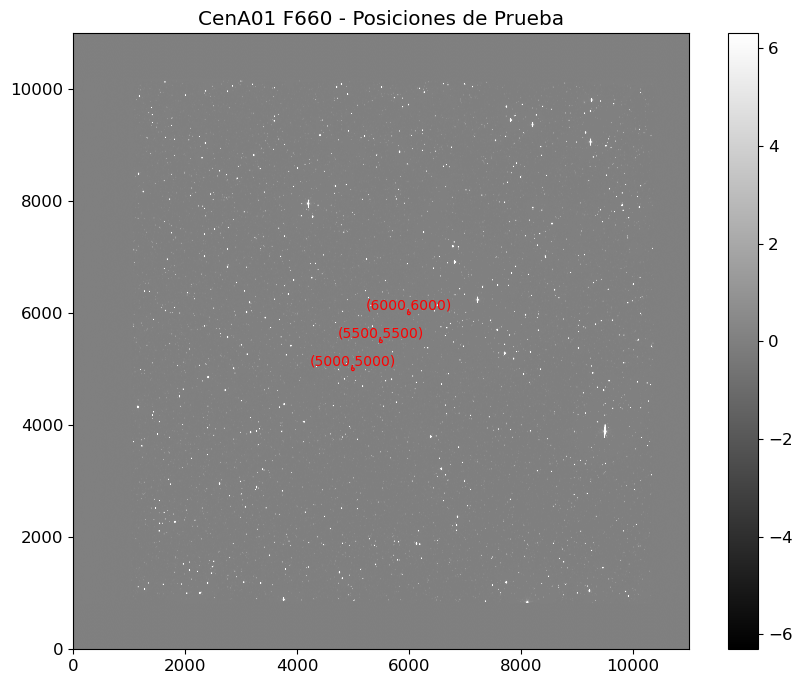


=== CenA01 F861 ===
Mediana: 0.000
Media: 0.118
Std: 6.295
Mínimo: -168.647
Máximo: 1092.444

Fotometría de prueba:
Posición [5500, 5500]: Flux = -4.023
  Flujo no positivo - no se puede calcular magnitud
Posición [6000, 6000]: Flux = 0.741
  Magnitud aproximada: 25.33
Posición [5000, 5000]: Flux = -1.325
  Flujo no positivo - no se puede calcular magnitud


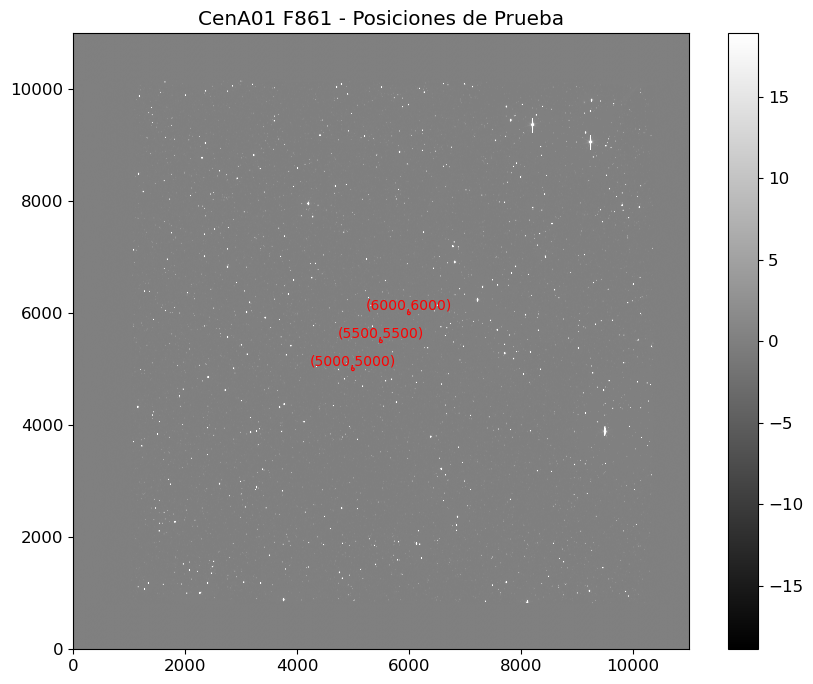


=== CenA01 F515 ===
Mediana: 0.000
Media: 0.057
Std: 4.137
Mínimo: -147.184
Máximo: 1384.088

Fotometría de prueba:
Posición [5500, 5500]: Flux = -0.523
  Flujo no positivo - no se puede calcular magnitud
Posición [6000, 6000]: Flux = 1.028
  Magnitud aproximada: 24.97
Posición [5000, 5000]: Flux = 2.749
  Magnitud aproximada: 23.90


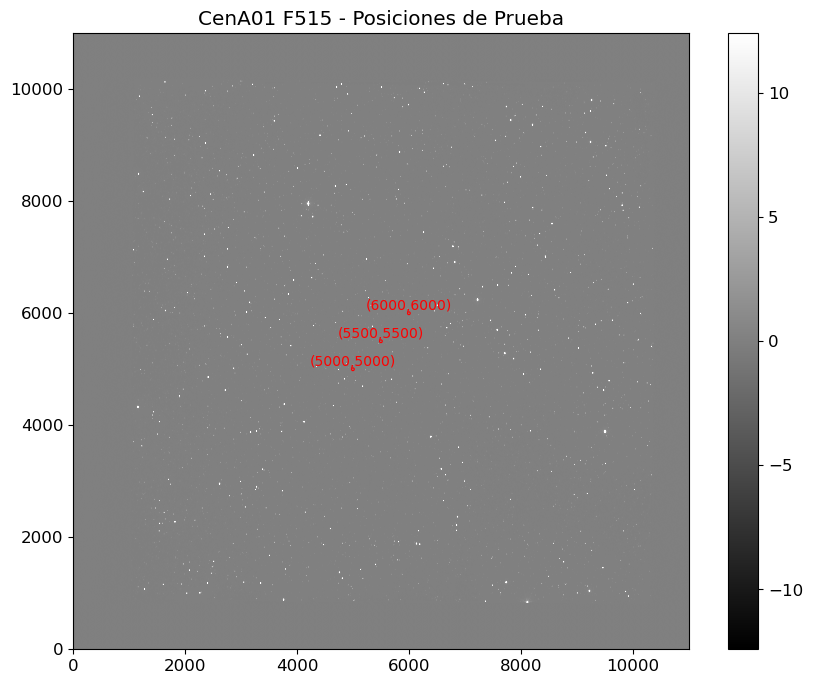

In [15]:
def verify_photometry_strategy(field_name, filter_name):
    """
    Verifica que la fotometría sin sustracción de fondo adicional funciona
    """
    image_path = f"../anac_data/{field_name}/{field_name}_{filter_name}.fits.fz"
    
    with fits.open(image_path) as hdul:
        data = hdul[1].data.astype(float)
    
    # Estadísticas de la imagen
    print(f"\n=== {field_name} {filter_name} ===")
    print(f"Mediana: {np.median(data):.3f}")
    print(f"Media: {np.mean(data):.3f}")
    print(f"Std: {np.std(data):.3f}")
    print(f"Mínimo: {np.min(data):.3f}")
    print(f"Máximo: {np.max(data):.3f}")
    
    # Seleccionar algunas posiciones de prueba (puedes usar coordenadas reales de cúmulos)
    test_positions = [
        [5500, 5500],  # Centro de la imagen
        [6000, 6000],  # Esquina
        [5000, 5000]   # Otra esquina
    ]
    
    # Fotometría simple
    from photutils.aperture import CircularAperture, aperture_photometry
    
    apertures = CircularAperture(test_positions, r=10)  # Radio de 10 píxeles
    phot_table = aperture_photometry(data, apertures)
    
    print("\nFotometría de prueba:")
    for i, position in enumerate(test_positions):
        flux = phot_table['aperture_sum'][i]
        print(f"Posición {position}: Flux = {flux:.3f}")
        
        # Calcular magnitud aproximada (necesitarías el zeropoint real)
        if flux > 0:
            mag_approx = 25 - 2.5 * np.log10(flux)  # Aproximación
            print(f"  Magnitud aproximada: {mag_approx:.2f}")
        else:
            print("  Flujo no positivo - no se puede calcular magnitud")
    
    # Visualizar las posiciones de prueba
    plt.figure(figsize=(10, 8))
    vmin = np.median(data) - 3 * np.std(data)
    vmax = np.median(data) + 3 * np.std(data)
    plt.imshow(data, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
    
    # Dibujar las aperturas de prueba
    for position in test_positions:
        circle = plt.Circle((position[0], position[1]), 10, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(circle)
        plt.text(position[0], position[1], f"({position[0]},{position[1]})", 
                color='red', fontsize=10, ha='center', va='bottom')
    
    plt.title(f'{field_name} {filter_name} - Posiciones de Prueba')
    plt.colorbar()
    plt.show()

# Probar con algunos filtros
for filter_name in ['F660', 'F861', 'F515']:
    verify_photometry_strategy("CenA01", filter_name)